## Loan Dataset

Dataset Link:  https://www.kaggle.com/datasets/burak3ergun/loan-data-set

### Important Libraries

In [1]:
import pandas as pd
from prince import FAMD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# calling the unencoded preprocessed dataset
df_unencoded = pd.read_csv('./loan_data_set_preprocessed_unencoded.csv')
df_unencoded.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
0,0.072991,-0.554487,-0.234815,0.273231,Male,No,0,Graduate,No,1.0,Urban,Y
1,-0.134412,-0.038732,-0.211017,0.273231,Male,Yes,1,Graduate,No,1.0,Rural,N
2,-0.393747,-0.554487,-0.948735,0.273231,Male,Yes,0,Graduate,Yes,1.0,Urban,Y
3,-0.462062,0.251980,-0.306207,0.273231,Male,Yes,0,Not Graduate,No,1.0,Urban,Y
4,0.097728,-0.554487,-0.056335,0.273231,Male,No,0,Graduate,No,1.0,Urban,Y


In [3]:
# reducing dimension to 2 using FAMD to plot in 2D
famd = FAMD(n_components=2, n_iter=3,
            copy=True, check_input=True,
            engine='scipy',random_state=42)

famd.fit(df_unencoded)

FAMD(engine='scipy', random_state=42)

In [4]:
# variance explained by 1st 2 components
famd.cumulative_percentage_of_variance_

array([14.39902025, 25.59999733])

In [5]:
# setupt for thw 2D plot
rep_2d = famd.row_coordinates(df_unencoded)
rep_2d.columns = ["Z1", "Z2"]
rep_2d["Loan_Status"] = df_unencoded["Loan_Status"]
rep_2d.head()

,Z1,Z2,Loan_Status
0,-1.874235,0.880437,Y
1,1.507935,-2.328013,N
2,0.919496,1.341293,Y
3,0.863034,-0.698978,Y
4,-1.856054,0.881859,Y


Text(0, 0.5, '2nd Component')

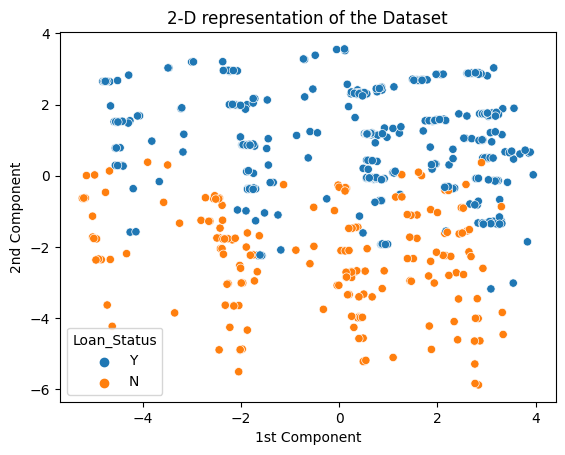

In [6]:
# 2D plot 
sns.scatterplot(x = "Z1", y = "Z2", data = rep_2d, hue = "Loan_Status")
plt.title("2-D representation of the Dataset")
plt.xlabel("1st Component")
plt.ylabel("2nd Component")

### Logistic Regression Model, With $L_1$ Regularization 

In [42]:
# calling the preprocessed data with L1 regularisation
df = pd.read_csv('./loan_data_set_preprocessed.csv')
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,0.072991,-0.554487,-0.234815,0.273231,1.0,1,0,0,0,0,0,0,0,1,1
1,-0.134412,-0.038732,-0.211017,0.273231,1.0,1,1,1,0,0,0,0,0,0,0
2,-0.393747,-0.554487,-0.948735,0.273231,1.0,1,1,0,0,0,0,1,0,1,1
3,-0.462062,0.251980,-0.306207,0.273231,1.0,1,1,0,0,0,1,0,0,1,1
4,0.097728,-0.554487,-0.056335,0.273231,1.0,1,0,0,0,0,0,0,0,1,1


In [47]:
# train test split
X = df.drop("Loan_Status_Y", axis=1).values
y = df["Loan_Status_Y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=26)

In [48]:
# fitting the Logistic Regression Model
logit_model = LogisticRegression(penalty='l1', solver='saga')
logit_model.fit(X_train, y_train)

e:\All Docs\Sayan\Desktop\Loan Dataset\laenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='l1', solver='saga')

In [49]:
# prediction
y_pred = logit_model.predict(X_test)

In [50]:
# fitted coefficiets
pd.DataFrame({
    "Features": ["Intercept"] + list(df.drop('Loan_Status_Y', axis=1).columns),
    "Coefficients": list(logit_model.intercept_)+list(logit_model.coef_[0])
})

,Features,Coefficients
0,Intercept,-2.509905
1,ApplicantIncome,0.046181
2,CoapplicantIncome,-0.222107
3,LoanAmount,-0.033904
4,Loan_Amount_Term,-0.042861
5,Credit_History,3.291128
6,Gender_Male,0.063461
7,Married_Yes,0.462271
8,Dependents_1,-0.578756
9,Dependents_2,0.203751


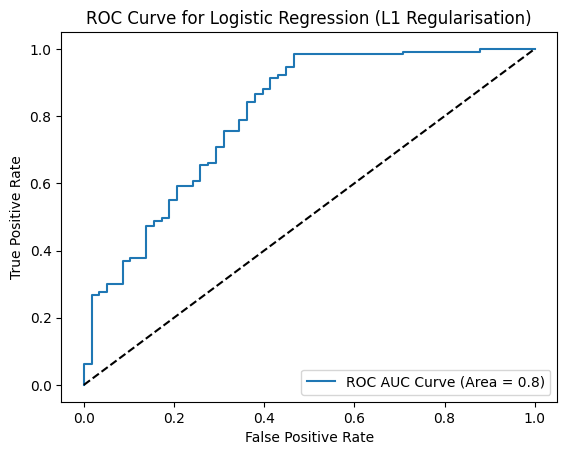

In [52]:
# ROC CUrve for the dataset
fpr, tpr, threshold = roc_curve(y_test, logit_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC AUC Curve (Area = {round(roc_auc, 2)})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve for Logistic Regression (L1 Regularisation)')
plt.legend(loc='lower right')
plt.show()

### Logistic Regression with reduced features

In [53]:
# calling the preprocessed dataset without encoding 
df_unencoded = pd.read_csv('./loan_data_set_preprocessed_unencoded.csv')
df_unencoded.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
0,0.072991,-0.554487,-0.234815,0.273231,Male,No,0,Graduate,No,1.0,Urban,Y
1,-0.134412,-0.038732,-0.211017,0.273231,Male,Yes,1,Graduate,No,1.0,Rural,N
2,-0.393747,-0.554487,-0.948735,0.273231,Male,Yes,0,Graduate,Yes,1.0,Urban,Y
3,-0.462062,0.251980,-0.306207,0.273231,Male,Yes,0,Not Graduate,No,1.0,Urban,Y
4,0.097728,-0.554487,-0.056335,0.273231,Male,No,0,Graduate,No,1.0,Urban,Y


In [54]:
# reducing the dimension to factors that explained 50% of the variation 
famd = FAMD(n_components=8, n_iter=3,
            copy=True, check_input=True,
            engine='scipy',random_state=42)

famd.fit(df_unencoded.drop("Loan_Status", axis=1))

FAMD(engine='scipy', n_components=8, random_state=42)

In [55]:
# cumulative percentage variation explained by selected factors
famd.cumulative_percentage_of_variance_

array([15.42801015, 26.41666309, 36.49951049, 46.10484249, 55.48097343,
       64.79603616, 73.03628374, 80.34740283])

In [56]:
# selected factors
rep_9d = famd.row_coordinates(df_unencoded)
rep_9d.columns = ["Z"+str(i+1) for i in range(8)]
rep_9d.head()

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8
0,1.862502,-0.141714,-1.970673,-0.472394,1.315812,1.483714,1.023013,-1.108653
1,-1.691114,-0.816804,0.485929,-1.372497,0.706063,0.624348,-4.062104,1.503420
2,-0.703721,-1.873285,0.497177,-1.907914,-0.866902,2.307853,2.231165,-2.623465
3,-0.702327,1.587440,-2.122779,-2.062676,0.823584,-1.555354,1.040973,-1.760877
4,1.841299,-0.158627,-1.942290,-0.459002,1.329667,1.513888,1.024412,-1.101398


In [57]:
# train test split
X = rep_9d.values
y = df_unencoded["Loan_Status"].replace({'Y':1, 'N':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=26)

In [58]:
# applying logit model
logit_model1 = LogisticRegression(penalty='l1', solver='saga')
logit_model1.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='saga')

In [59]:
# prediction
y_pred = logit_model1.predict(X_test)

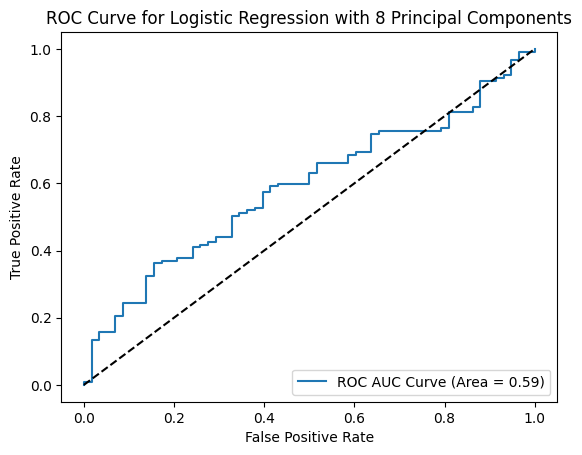

In [60]:
# ROC curve
fpr, tpr, threshold = roc_curve(y_test, logit_model1.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC AUC Curve (Area = {round(roc_auc, 2)})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve for Logistic Regression with 8 Principal Components')
plt.legend(loc='lower right')
plt.show()

### Support Vector Machines

In [61]:
# calling the peprocessed data
df = pd.read_csv("./loan_data_set_preprocessed.csv")
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,0.072991,-0.554487,-0.234815,0.273231,1.0,1,0,0,0,0,0,0,0,1,1
1,-0.134412,-0.038732,-0.211017,0.273231,1.0,1,1,1,0,0,0,0,0,0,0
2,-0.393747,-0.554487,-0.948735,0.273231,1.0,1,1,0,0,0,0,1,0,1,1
3,-0.462062,0.251980,-0.306207,0.273231,1.0,1,1,0,0,0,1,0,0,1,1
4,0.097728,-0.554487,-0.056335,0.273231,1.0,1,0,0,0,0,0,0,0,1,1


In [62]:
# train test split
X = df.drop("Loan_Status_Y", axis=1).values
y = df["Loan_Status_Y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=26)

In [63]:
# support vector machine Model
svm_model = SVC(C=0.8, kernel='rbf', probability=True)
svm_model.fit(X, y)

SVC(C=0.8, probability=True)

In [64]:
# prediction
y_pred = svm_model.predict(X_test)

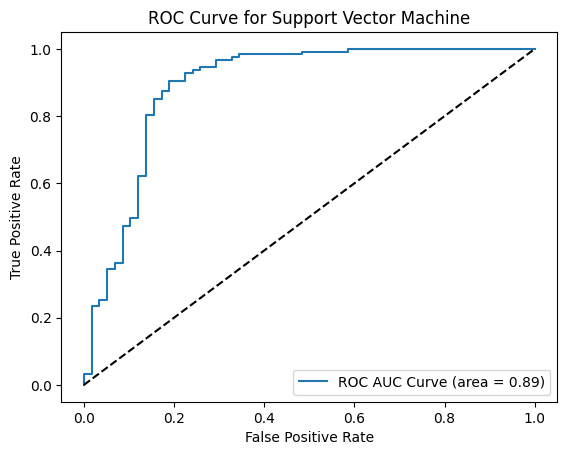

In [66]:
# ROC Curve
fpr, tpr, threshold = roc_curve(y_test, svm_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC AUC Curve (area = {round(roc_auc, 2)})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Support Vector Machine")
plt.legend(loc="lower right")

In [28]:
# choosing thresh-hold for classification
acc_meas = [x*(1-y) for (x, y) in zip(tpr, fpr)]
best_thresh = threshold[acc_meas.index(max(acc_meas))]
best_thresh

0.79986614089742

In [29]:
svm_model.decision_function_threshold = best_thresh

In [30]:
# prediction based on best threshold
y_pred = svm_model.predict(X_test)

In [36]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm))

    0    1
0  32   26
1   2  125


In [38]:
# classification report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.55      0.70        58
           1       0.83      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.88      0.77      0.80       185
weighted avg       0.86      0.85      0.84       185



In [41]:
# saving the model
with open('./svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)